# Temperature-Salinity diagram using MOM6 output

This notebook shows how to plot a temperature-salinity diagram which is weighted by volume using xhistogram. 

The notebook is written using output from MOM6. If you want to use output from MOM5 the relevant diagnostics are as follows;
- Temperature: `temp` (in MOM6 this is `thetao`)
- Salinity: `salt`    (in MOM6 this is `so`)
  
In MOM6, there is a tracer cell volume diagnostic (`volcello`). There is no output diagnostic equivalent in MOM5, however you can calculate the tracer cell volume by multiplying the tracer cell area (`area_t`) by the tracer cell thickness (`dzt`). 

Note that the coordinate (lat and lon) names also differ between MOM6 and MOM5. In MOM6, the tracer longitude coordinate is labelled `xh`, the tracer latitude coordinate is labelled `yh`, and the tracer vertical coordinate is `z_l`. In MOM5, the tracer longitude coordinate is labelled `xt_ocean`, the tracer latitude coordinate is labelled `yt_ocean`, and the tracer vertical coordinate is `st_ocean`. 

**Requirements**: The conda/analysis3 (or later) module on ARE. A session with 4 cores is sufficient for this example but more cores will be needed for larger datasets. 

Firstly, we load all required modules and start a client.

In [1]:
# analysis libraries
import pandas as pd
import xarray as xr
import numpy as np
import gsw
from xhistogram.xarray import histogram as xhistogram

# intake and Dask
import intake
catalog = intake.cat.access_nri
from dask.distributed import Client

# plotting libaries
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import matplotlib.colors as colors

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42629,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33341,Total threads: 1
Dashboard: /proxy/44249/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:43669,


## Load data

Choose an experiment of any resolution. Here, only 1 year of the MOM6 `panant-01-zstar-v13` experiment is selected; if you want to use a longer time period, you might need more resources!

In [3]:
experiment = "panant-01-zstar-v13"
start_time = "1991-01-01"
end_time = "1991-12-31"

### Load the data

We define a function below to load output (temperature or salinity) on which we will compute the histogram for the T-S diagram.

In [4]:
def load_data(variable, frequency='1mon', file_id=None, start_time=None, end_time=None):
    
    '''
    variable: string defining the variable to load (e.g. `thetao` or `so`)
    '''

    catalog_subset = catalog[experiment]
    variable_search = catalog_subset.search(variable=variable, frequency=frequency)
    if file_id is not None:
        variable_search = variable_search.search(file_id=file_id)
        
    darray = variable_search.to_dask(xarray_open_kwargs={"decode_timedelta": False})

    darray = darray.get(variable)
    
    if 'time' in darray.coords:
        darray = darray.sel(time=slice(start_time, end_time))
    
    return darray
    

Now load the data using this function. 

In [5]:
salt = load_data('so', start_time=start_time, end_time=end_time)
temperature = load_data('thetao', start_time=start_time, end_time=end_time)
cell_volume = load_data('volcello', file_id='ocean.1mon.nv:2.xh:3600.xq:3601.yh:845.yq:846.z_i:76.z_l:75', start_time=start_time, end_time=end_time)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

### Subset the data regionally

Select the region and coordinates of meridional section for the temperature-salinity diagram.

In [6]:
longitude = -25  # longitude of meridional section
latitude_range = slice(-90, -37)  # latitude range of section

Now define a function to select out this region of interest. 

In [7]:
def select_region(darray, longitude, latitude_range):

    '''
    Subset the data array to the defined region. 
    '''

    darray_subset = darray.sel(xh=longitude, method='nearest').sel(yh=latitude_range)

    return darray_subset

And we subset the previously loaded data using this function. 

In [8]:
salt = select_region(salt, longitude, latitude_range)
temperature = select_region(temperature, longitude, latitude_range)
cell_volume = select_region(cell_volume, longitude, latitude_range)

### Convert Temperature and Salinity units

Now we need to convert from potential temperature to conservative temperature and from practical salinity to absolute salinity. If adapting this to MOM5 output, make sure you check the temperature and salinity definitions/units - they may be different than for MOM6! To learn more about the different types of salinity and temperature measurements, and how to convert between them, visit the `GSW` toolbox: https://teos-10.github.io/GSW-Python/intro.html

In [9]:
# Calculate ocean pressure (gsw assumes ocean depth is positive upwards, 
# hence the negative applied here)
pressure = gsw.p_from_z(-salt.z_l, salt.yh)

# This converts pratical salinity (psu) to absolute salinity (g/kg)
SA = gsw.SA_from_SP(salt, pressure, salt.xh, salt.yh)
SA.attrs = {'units': 'Absolute Salinity (g/kg)'}

# This converts potential temperature (deg C) to conservative temperature (deg C)
CT = gsw.CT_from_pt(salt, temperature)
CT = CT.rename('thetao')
CT.attrs = {'units': 'Conservative temperature (°C)'}

Now load the converted data into memory. Note: You don't need to load the data into memory to run the rest of the script but it can make subsequent calculations faster. However, if you choose to load more data (e.g. a larger region or longer timeframe) then this step might cause the kernel to die. 

In [10]:
CT = CT.compute()
SA = SA.compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 17.40 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


### Compute T-S histogram

Now define the function that computes the temperature and salinity bins for the T-S histogram. 

In [11]:
def compute_TS_bins(salt, temperature, volume):
    
    temp_bins = np.arange(np.floor(temperature.min().values)-0.5, np.ceil(temperature.max().values)+0.6, 0.5)
    salt_bins = np.arange(np.floor(salt.min().values)-0.1, np.ceil(salt.max().values)+0.11, 0.1)
    
    # To create density contours in the T-S diagram
    temp_bins_mesh, salt_bins_mesh = np.meshgrid(temp_bins, salt_bins)
    TS_density = gsw.density.sigma2(salt_bins_mesh, temp_bins_mesh)
    
    # Create the 2D histogram array containing the temperature and salinity values, 
    # weighted by grid cell volume
    TS_histogram = xhistogram(temperature, salt, bins=(temp_bins, salt_bins), weights=volume)
    TS_histogram = TS_histogram.where(TS_histogram != 0).compute()
    
    return TS_histogram, TS_density, salt_bins_mesh, temp_bins_mesh 

Calculate the histogram. 

In [12]:
%%time
TS_histogram, TS_density, salt_bins_mesh, temp_bins_mesh = compute_TS_bins(SA, CT, cell_volume)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 19.73 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 4.52 s, sys: 388 ms, total: 4.91 s
Wall time: 4.94 s


### Plot the histogram

Now we can plot this T-S histogram!

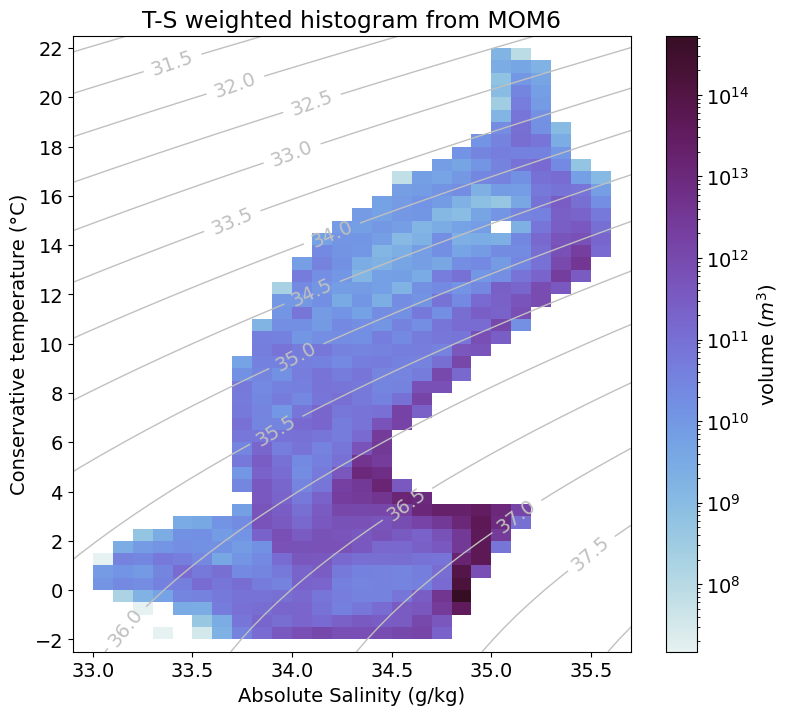

In [13]:
plt.rcParams['font.size']=14
plt.figure(figsize=(9, 8))

# normalize the colorbar to the min and maximum values of the histogram 
# using a LogNormal scale
norm=colors.LogNorm(vmin=TS_histogram.min().values, vmax=TS_histogram.max().values)

# Plot (shade) the TS histogram data
TS_histogram.plot(cmap=cmo.dense, norm=norm, cbar_kwargs=dict(label='volume ($m^{3}$)'))

# Add the density contours
cs = plt.contour(salt_bins_mesh, temp_bins_mesh, TS_density, 
                 colors='silver', linewidths=1, 
                 levels=np.arange(np.floor(TS_density.min()), np.ceil(TS_density.max()), .5))
plt.clabel(cs, inline=True)

plt.xlabel(SA.units)
plt.ylabel(CT.units)
plt.title("T-S weighted histogram from MOM6");

plt.xlim([32.9, 35.7])
plt.yticks(np.arange(-2, 23, 2))

plt.show()